<a href="https://colab.research.google.com/github/rpdahxn/HandsOnML/blob/main/17_autoencoders_and_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def plot_image(image):
  plt.imshow(image, cmap = 'binary')
  plt.axis('off')

## 17.2 과소완전 선형 오토인코더로 PCA 수행하기

3D 데이터셋을 만든다.

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

오토인코더를 만든다.

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape = [3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape = [2]))

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mse', optimizer = keras.optimizers.SGD(learning_rate = 1.5))

In [6]:
history = autoencoder.fit(X_train, X_train, epochs = 20)

Epoch 1/20
2/2 [==============================] - 0s 10ms/step - loss: 0.1576
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0698
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0808
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.1614
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.1213
Epoch 6/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0409
Epoch 7/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0279
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 10/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0087
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0072
Epoch 13/20
2/2 [==============================] - 0s 7ms/step - los

In [7]:
codings = autoencoder.predict(X_train)

오토인코더는 데이터에 있는 분산이 가능한 많이 보존되도록 데이터를 투영할 최상의 2D 평면을 찾는다.

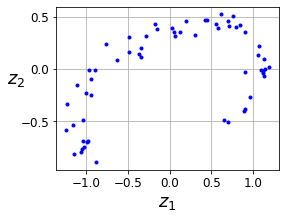

In [8]:
fig = plt.figure(figsize = (4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize = 18)
plt.ylabel("$z_2$", fontsize = 18, rotation = 0)
plt.grid(True)
plt.show()

## 17.3 적층 오토인코더